# EE 617 Project: Sensor Diagnosis-Part 1

## Induction Motor Sensor Fault Diagnose

This work is built upon state estimation of Induction Motor State Estimation with Kalman Filters. Since EKF was found to perform very well, it is used here for sensor fault diagnosis. The aim is to diagnose sensors for faults in real time and also to keep the computational strategy light and simple to be implementable on a micro-controller as well.

### Induction Motor

The model is same as used in our previous work
(give link)

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import random
import scipy.linalg as sp

In [58]:
class IMotor(object):
    
    def __init__(self):
        
        #States
        self.x1=0.2
        self.x2=-0.6
        self.x3=-0.4
        self.x4=0.1
        self.x5=0.3
        
        #Parameters
        self.k1=-0.186
        self.k2=0.178
        self.k3=0.225
        self.k4=-0.234
        self.k5=-0.081
        self.k6=4.643
        self.k7=-4.448
        self.k8=1
        
    def y1(self):
        return self.k7*self.x1+self.k8*self.x3
    
    def y2(self):
        return self.k7*self.x2+self.k8*self.x4
    
    def dxdt(self, z):
        
        z1=z[0]
        z2=z[1]
        z3=z[2]
        
        dx1dt = self.k1*self.x1 + z1*self.x2 + self.k2*self.x3 + z2
        dx2dt = -z1*self.x1 + self.k1*self.x2 + self.k2*self.x4
        dx3dt = self.k3*self.x1 + self.k4*self.x3 + (z1-self.x5)*self.x4
        dx4dt = self.k3*self.x2 - (z1-self.x5)*self.x3 + self.k4*self.x4
        dx5dt = self.k5*(self.x1*self.x4-self.x2*self.x3)+self.k6*z3
        
        return np.array([dx1dt, dx2dt, dx3dt, dx4dt, dx5dt])
        
    def setState(self, X):
        self.x1=X[0]
        self.x2=X[1]
        self.x3=X[2]
        self.x4=X[3]
        self.x5=X[4]
        
    def setX5(x5):
        self.x5=x5
    
        
    def getState(self):
        
        return np.array([self.x1, self.x2, self.x3, self.x4, self.x5])
    
    def update(self, delt, z, noise=False):
        #Use RK4 method to integrate
        
        #Initialise
        h=delt
        X0=self.getState()
        
        #K1 terms
        K1=h*self.dxdt(z)
        X1=X0+K1/2
        self.setState(X1)
        
        #K2 terms
        K2=h*self.dxdt(z)
        X2=X0+K2/2
        self.setState(X2)
        
        #K3 terms
        K3=h*self.dxdt(z)
        X3=X0+K3
        self.setState(X3)
        
        #K4 terms
        K4=h*self.dxdt(z)
        X=X0+K1/6+K2/3+K3/3+K4/6
        if noise==True:
            R=np.identity(5)*1e-4
            X+=np.random.multivariate_normal([0, 0, 0, 0, 0], R)
        self.setState(X)
        
    def update2(self, delt, z, noise=False):
        
        X=self.getState()
        X+=delt*self.dxdt(z)
        if noise==True:
            R=np.identity(5)*1e-4
            X+=np.random.multivariate_normal([0, 0, 0, 0, 0], R)
        self.setState(X)
        
        
    def linMod(self, Z):
        
        Z1=Z[0]
        Z2=Z[1]
        Z3=Z[2]
        
        X=self.getState()
        X1=X[0]
        X2=X[1]
        X3=X[2]
        X4=X[3]
        X5=X[4]
        
        a1=[self.k1, Z1, self.k2, 0, 0]
        a2=[-Z1, self.k1, 0, self.k2, 0]
        a3=[self.k3, 0, self.k4, (Z1-X5), -X4]
        a4=[0, self.k3, -(Z1-X5), self.k4, X3]
        a5=[self.k5*X4, -self.k5*X3, -self.k5*X2, self.k5*X1, 0]
        
        A=[a1, a2, a3, a4, a5]
        A=np.array(A)
        
        c1=[X2, 1, 0]
        c2=[-X1, 0, 0]
        c3=[X4, 0, 0]
        c4=[-X3, 0, 0]
        c5=[0, 0, self.k6]
        
        D=[c1, c2, c3, c4, c5]
        D=np.array(D)
        
        return A, D
        
    def meas(self, noise=True):
        
        x=self.getState()
        y1=self.k7*x[0]+self.k8*x[2]
        y2=self.k7*x[1]+self.k8*x[3]
        Y=np.array([y1, y2])
        
        if noise:
            R=np.identity(2)*1e-2
            Y+=np.random.multivariate_normal([0, 0], R)
        
        return Y
    
    def linMeas(self):
        
        y1=[self.k7, 0, self.k8, 0, 0]
        y2=[0, self.k7, 0, self.k8, 0]
        
        
        C=[y1, y2]
        
        return np.array(C)
        

In [59]:
def dxdt(X, z, t=0):
    
    k1=-0.186
    k2=0.178
    k3=0.225
    k4=-0.234
    k5=-0.081
    k6=4.643
        
    z1=z[0]
    z2=z[1]
    z3=z[2]
    
    x1=X[0]
    x2=X[1]
    x3=X[2]
    x4=X[3]
    x5=X[4]
        
    dx1dt = k1*x1 + z1*x2 + k2*x3 + z2
    dx2dt = -z1*x1 + k1*x2 + k2*x4
    dx3dt = k3*x1 + k4*x3 + (z1-x5)*x4
    dx4dt = k3*x2 - (z1-x5)*x3 + k4*x4
    dx5dt = k5*(x1*x4-x2*x3)+k6*z3
        
    return np.array([dx1dt, dx2dt, dx3dt, dx4dt, dx5dt])

def Gx(X):
    
    x1=X[0]
    x2=X[1]
    x3=X[2]
    x4=X[3]
    
    k7=-4.448
    k8=1
    
     
    y1 = k7*x1 + k8*x3
    y2 = k7*x2 + k8*x4
    
    return np.array([y1, y2])

In [60]:
def IMlin(x, z):
    
    k1=-0.186
    k2=0.178
    k3=0.225
    k4=-0.23
    k5=-0.081
    k6=4.643
    
    dx1=np.array([k1, z[0], k2, 0, 0])
    dx2=np.array([-z[0], k1, 0, k2, 0])
    dx3=np.array([k3, 0, k4, z[0]-x[4], -x[3]])
    dx4=np.array([0, k3, -(z[0]-x[4]), k4, x[2]])
    dx5=np.array([k5*x[3], -k5*x[2], -k5*x[1], k5*x[0], 0])
    
    A=np.array([dx1, dx2, dx3, dx4, dx5])
    
    dz1=np.array([x[1], 1, 0])
    dz2=np.array([-x[0], 0, 0])
    dz3=np.array([x[3], 0, 0])
    dz4=np.array([-x[2], 0, 0])
    dz5=np.array([0, 0, k6])
    
    B=[dz1, dz2, dz3, dz4, dz5]
    B=np.array(B)
    
    C=np.identity(5)
    return A, B, C

def IMeas(x):
    
    k7=-4.448
    k8=1
    
    y1=np.array([k7, 0, k8, 0, 0])
    y2=np.array([0, k7, 0, k8, 0])
    
    C=[y1, y2]
    
    return np.array(C)

### Sensor Model

Since we are simulating faults, a special class "Sensor" was defined, which can be customised to a particular model and noise and can simulate offset, drift and erractic fault. Also another function smoother, which is basically a low pass filter, it takes average of last $N$ values of an array and outputs an array with original length - $N$.

If sensor model is given as $Y=G(X)+v$, $Y$ being measurement, $G$ being measurement model, $X$ the state, $v$ the measurement noise

Then faults are simulated as 

$Y=G(X)+v+\Delta u(t-t_0)$, where $t$ is time, $t_0$ when failt occurs, $\Delta$ is the offset

$Y=G(X)+v+mtu(t-t_0)$, $m$ is drift coeeficient

$Y=G(X)+V$, here $V$ is zero-mean gaussian noise with Variance being $m$ times that of $v$


*Add Image of sensor faults

In [61]:
class Sensor(object):
    
    #A very generic Sensor Class
    
    def __init__(self):
        
        #Healthy when initialised
        
        self.offset = 0    #Offset 
        self.drift = 0     #Drift Coefficient
        self.Fault = False #No fault yet
        self.model = None  #Expected to be a function G(x)
        self.R = 0         #Noise Matrix
        self.t = 0         #time for drift fault
        
    def setOffset(self, d):
        
        #set offset
        self.offset=d
        self.Fault=True  #No longer healthy :((
        
    def setDrift(self, m):
        
        #set Drift
        self.drift=m
        self.t=0        #Now starting the timer for drift
        self.Fault=True #No longer healthy :((
        
    def setModel(self, g, R):
        
        #Modify sensor for a particular measurement model
        self.model=g
        self.R=R
        
    def meas(self, X):
        
        #Measure with the model and add noise. Add offset and/or drift if any
        n, m=self.R.shape
        a=self.model(X)+self.offset+self.drift*self.t+np.random.multivariate_normal(np.zeros(n), self.R)
        self.t+=1  #update time
        return a
    
    def erraticScale(self, m):
        
        #scale the variance matrix of noise by m, for erractic fault
        self.R=m*self.R
        self.Fault=True
        
    def clear(self):
        
        #clean the sensor of any fault
        self.fault=False            #Healthy Again :))
        self.drift=0*self.drift
        self.t=0
        self.offset=0*self.offset
        
def smoother(E, N):
    
    #This signal basically removes high frequency components of noise and gives a smooth output signal
    
    #E - > the error signal
    #N - > last N values to be smooth, i.e. the output signal is average of last N values
    
    L=len(E)
    A=[]        
    s=sum(E[:N])  #running sum
    
    for i in range(N, L):
        A.append(s/N)     #Average of last N values
        s+=E[i]           #Add the next value
        s-=E[i-N]         #Remove the value from N iterations ago
        
    #This way of storing the sum, we dont have to spend too much memory on storing all N values :))
        
    return A

### Simulate motor with sensor offset

A function "OffsetPerformance" is defined which simulates the motor, its sensor and fault at a particular time instant and EKF estimation of its states. Also, along with the usual Kalman Filter error signal we are running another motor model in parallel using simple Euler Integration and obtaining its measurements from measurement model. Since we expect this algorithm to be on a microcontroller, so we are using simple Euler method for it. For actual motor, we are using RK-4th order method for integration. The difference between actual measurements and this other motor model measurement simulation gives another error signal. Hence we obtain two error signals.

In [77]:
def OffPerformance(t=300, A=np.array([0.2, 0]), N=500):
    
    #Lets do simulation of motor with dynamic input as was done in our Kalman Filter File
    
    #t is the time when fault occurs
    #A is offset values, since here we have 2 sensors, we are introducing offset in just the first sensor
    #N is the time until when the simulation is going to run
    
    #Create the sensor
    R=np.identity(2)*1e-2
    msens=Sensor()
    msens.setModel(Gx, R)
    
    
    #Simulation
    
    #initialising Motor and arrays for storing data
    a=IMotor()          #Motor Instance
    X=a.getState()      #Initial state
    x0=X  
    X5=[]               #Store the X5
    U1=[]               #Store input 1
    U2=[]               #Store input 2
    Y1=[]               #Store measurement 1
    Y2=[]               #Store measurement 2
    X5=[]
    
    #Simulate with Input [1, 1, 0]
    for i in range(0, 500):
        
        U1.append(1)
        U2.append(1)
        a.update(0.1, [U1[i], U2[i], 0], True)
        X=a.getState()
        X5.append(X[4])
        y=msens.meas(a.getState())
        Y1.append(y[0])
        Y2.append(y[1])
        
        #If now is the time, induce fault
        if i==t:
            msens.setOffset(A)
            
    #Simulate with Input [1.2, 1, 0]
    for i in range(500, 700):
        U1.append(1.2)
        U2.append(1)
        a.update(0.1, [U1[i], U2[i], 0], True)
        X=a.getState()
        X5.append(X[4])
        y=msens.meas(a.getState())
        Y1.append(y[0])
        Y2.append(y[1])
        
        #If now is the time, induce fault
        if i==t:
            msens.setOffset(A)
            
    #Simulate with Input [0.8, 1, 0]      
    for i in range(700, 900):
        U1.append(0.8)
        U2.append(1)
        a.update(0.1, [U1[i], U2[i], 0], True)
        X=a.getState()
        X5.append(X[4])
        y=msens.meas(a.getState())
        Y1.append(y[0])
        Y2.append(y[1])
        
        #If now is the time, induce fault
        if i==t:
            msens.setOffset(A)
            
    #Simulate with Input [1, 1, 0]
    for i in range(900, N):
        U1.append(1)
        U2.append(1)
        a.update(0.1, [U1[i], U2[i], 0], True)
        X=a.getState()
        X5.append(X[4])
        y=msens.meas(a.getState())
        Y1.append(y[0])
        Y2.append(y[1])
        
        #If now is the time, induce fault
        if i==t:
            msens.setOffset(A)

    
    #Extended Kalman Filter Estimation, along with dummy model (run on microcontroller) simulation
    
    
    P0=np.identity(5)   #Initial Variance Estimate
    Qd=np.identity(5)*1e-4
    C=a.linMeas()       
    P=P0
    x=x0
    T=0.1
    Xplot=[]
    
    E1=[]
    E2=[]
    
    Dragon=IMotor()     #Dummy Motor
    
    for i in range(0, N):
    
        Z=[U1[i], U2[i], 0]   #Input
        Dragon.update2(0.1, Z, False)    #Dummy motor simulated with Euler Integration, and no model noise    
    
    #Form the linear model
        A, dump, B=IMlin(x0, Z)
        Phi=sp.expm(A*T)
        Tau=np.linalg.multi_dot([Phi-np.identity(5), np.linalg.inv(A), B])
    
    #Prediction
        x+=T*dxdt(x, Z)
        P=np.linalg.multi_dot([Phi, P, np.transpose(Phi)])+np.linalg.multi_dot([Tau, Qd, np.transpose(Tau)])
    
    #Kalman Gain Matrix
        C=IMeas(x)
        t1=np.linalg.multi_dot([C, P, np.transpose(C)])+R
        t2=np.linalg.inv(t1)
        L=np.linalg.multi_dot([P, np.transpose(C), t2])
        
    #Update Step
        Y=[Y1[i], Y2[i]]
        
        e=np.array(Y)-Gx(x)
        E1.append(e)           #Kalman Error (its array of 2x1 vectors)
        
        e2=Dragon.meas(False)-Gx(x)
        E2.append(e2)          #Dummy motor model error (its array of 2x1 vectors)
        
    #Update Step
        x+=np.dot(L, e)
        P=np.dot(np.identity(5)-np.dot(L, C), P)
    
    #Store data for plotting
        Xplot.append(x[-1])
        
    E1=np.array(E1)
    E2=np.array(E2)
    
    #Return measurement 1, 2; State X5 estimation; error signal of EKF for both sensors; error signal due to difference between 
    #simple motor model measurent simulation; and actual state X5 respectively
    
    return Y1, Y2, Xplot, E1, E2, X5  

Now we perform simulation for $4000$ time steps while giving offset to first sensor of $0.74$ at $1200^{th}$ time step. Then we smooth out the error signals (last 100 time steps) and plot their difference

In [78]:
Y1, Y2, Xplot, E1, E2, X5=OffPerformance(1200, np.array([0.74,  0]), 4000)

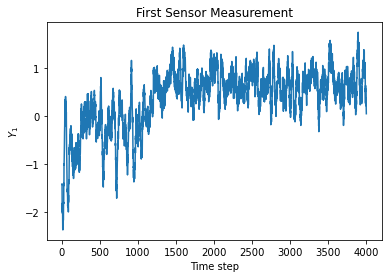

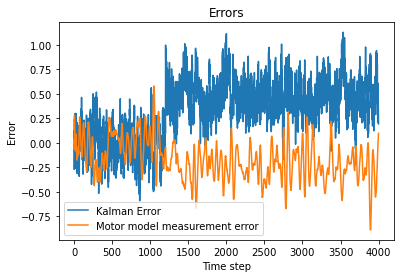

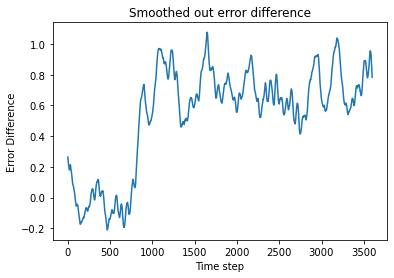

In [79]:
E1s=smoother(E1[300:, 0], 100)    #Smooth the Kalman Error from first sensor
E2s=smoother(E2[300:, 0], 100)    #Smooth the motor model measurement error from first sensor

Ediff=[]

for i in range(0, len(E1s)):
    Ediff.append(E1s[i]-E2s[i])
    
plt.plot(Y1)         #Plot the first Sensor measurements (the one that is simulated for faults)
plt.xlabel("Time step")
plt.ylabel('$Y_1$')
plt.title("First Sensor Measurement")
plt.show()         

plt.plot(E1[:, 0])   #Plot Kalman Error for first sensor
plt.plot(E2[:, 0])   #Plot motor model measurement error from first sensor
plt.xlabel("Time step")
plt.ylabel('Error')
plt.title("Errors")
plt.legend(['Kalman Error', 'Motor model measurement error'])
plt.show()

plt.plot(Ediff)      #Plot smoothed out difference
plt.xlabel("Time step")
plt.ylabel('Error Difference')
plt.title("Smoothed out error difference")
plt.show()

#### Real Time fault detection strategy

From the above figure, it seems that the smoothed error difference provides a good indication of fault occurence. Initially this signal oscillates about $0$. Then after offset, it oscillates about the offset value. Hence, not only it can flag a fault but also report the offset which might even be used for self callibration to avoid disrupting the process. To detect this phenomenon in real time, a zero-cross detector is implemented which works like this -> If the signal hasn't crossed $0$ for some time, then its off by some value and reports the average value since last zero crossing reporting it as the offset.

In [80]:
def zeroCrossdetector(Ediff, l):
    
    s=0             #Sum since last zero crossing
    count=0         #Instants since last zero crossing
    
    
    for i in range(0, len(Ediff)):
        
        #If I come too close to 0 mark it as Okay, here I am assuming 0.15 offset wont cause any problem
        #Usually this value is to be experimentally determined, here I obtained it with trial and error
        
        if abs(Ediff[i]-0)<0.15:
            
            #since I cross zero, make the sum 0 again, and the count also 0 again
            s=0
            count=0
        
        else:
            
            #Add the Signal Value to Ediff and increment count
            s+=Ediff[i]
            count+=1
          
    #If count greater then l, that is for very long I didn't cross zero, mark it as offset and return average of last l terms
        if count>l:
            return s/count
        
    #else just return 0
    return 0

In [84]:
zeroCrossdetector(Ediff[500:], 100)

0.5348719594331977

The above value is the value reported against simulated 0.74, by increasing 'l' we are likely to get better estimate. I would like to also no how effective my scheme is. Hence another function that automates this process and produces some results is built below. We shall use this data to see depending upon offset value, with what probability its detected.

In [96]:
def QuantifyPerformance(Offset, N=100, smoothtime=100, l=50):
    
    #This function is built to quantify performance of our scheme
    
    #N->Number of simulations
    #Now perform the same above experiment N (default 100) times for a given offset
    
    Ediff_data=[]      #Store the zero-cross detector's output for all 100 simulations in an array
    for i in range(N):
        
        Y1, Y2, Xplot, E1, E2, X5=OffPerformance(1000, np.array([Offset,  0]), 2000)  #Perform the experiment
        
        #Smooth the error signals and take their difference
        E1s=smoother(E1[300:, 0], smoothtime)
        E2s=smoother(E2[300:, 0], smoothtime)
        
        Ediff=[]
        for i in range(0, len(E1s)):
            Ediff.append(E1s[i]-E2s[i])
            
        #Add the findings of zero-cross detector to Ediff_data
        Ediff_data.append(zeroCrossdetector(Ediff, l))
        
    return Ediff_data

Ediff_state0=QuantifyPerformance(0)
Ediff_state2=QuantifyPerformance(0.1)
Ediff_state4=QuantifyPerformance(0.2)
Ediff_state6=QuantifyPerformance(0.3)
Ediff_state8=QuantifyPerformance(0.4)
Ediff_state0=QuantifyPerformance(0.5)
Ediff_state2=QuantifyPerformance(0.6)
Ediff_state4=QuantifyPerformance(0.7)
Ediff_state6=QuantifyPerformance(0.8)
Ediff_state8=QuantifyPerformance(0.9)
Ediff_state10=QuantifyPerformance(1)

In [86]:
def DriftPerformance(t=300, A=np.array([0.2, 0]), N=1000):
    
    #Lets simulate the drift fault at time t, with drift coeffiecients in A for N time steps
    
    #Intialising and simulating the motor and EKF as in "Offperformance"
    
    R=np.identity(2)*1e-2
    msens=Sensor()
    msens.setModel(Gx, R)
    
    a=IMotor()
    X=a.getState()
    x0=X
    X5=[]
    U1=[]
    U2=[]
    Y1=[]
    Y2=[]
    C=a.linMeas()
    X5=[]
    for i in range(0, 500):
        U1.append(1)
        U2.append(1)
        a.update(0.1, [U1[i], U2[i], 0], True)
        X=a.getState()
        X5.append(X[4])
        y=msens.meas(a.getState())
        Y1.append(y[0])
        Y2.append(y[1])
        if i==t:                  #Induce fault if its the right time
            msens.setDrift(A)     #I meant drift fault here
            
    
    for i in range(500, 700):
        U1.append(1.2)
        U2.append(1)
        a.update(0.1, [U1[i], U2[i], 0], True)
        X=a.getState()
        X5.append(X[4])
        y=msens.meas(a.getState())
        Y1.append(y[0])
        Y2.append(y[1])
        if i==t:                  #Induce fault if its the right time
            msens.setDrift(A)     #I meant drift fault here
            
            
    for i in range(700, 900):
        U1.append(0.8)
        U2.append(1)
        a.update(0.1, [U1[i], U2[i], 0], True)
        X=a.getState()
        X5.append(X[4])
        y=msens.meas(a.getState())
        Y1.append(y[0])
        Y2.append(y[1])
        if i==t:                  #Induce fault if its the right time
            msens.setDrift(A)     #I meant drift fault here
            
            
    for i in range(900, N):
        U1.append(1)
        U2.append(1)
        a.update(0.1, [U1[i], U2[i], 0], True)
        X=a.getState()
        X5.append(X[4])
        y=msens.meas(a.getState())
        Y1.append(y[0])
        Y2.append(y[1])
        if i==t:                  #Induce fault if its the right time
            msens.setDrift(A)     #I meant drift fault here

    
    P0=np.identity(5)
    Qd=np.identity(5)*1e-4
    P=P0
    x=x0
    T=0.1
    Xplot=[]
    E1=[]
    E2=[]
    Dragon=IMotor()
    for i in range(0, N):
    
        Z=[U1[i], U2[i], 0]
    #Form the linear model
        Dragon.update2(0.1, Z, False)
        A, dump, B=IMlin(x0, Z)
        Phi=sp.expm(A*T)
        Tau=np.linalg.multi_dot([Phi-np.identity(5), np.linalg.inv(A), B])
    
    #Prediction
        x+=T*dxdt(x, Z)
        P=np.linalg.multi_dot([Phi, P, np.transpose(Phi)])+np.linalg.multi_dot([Tau, Qd, np.transpose(Tau)])
    
    #Kalman Gain Matrix
        C=IMeas(x)
        t1=np.linalg.multi_dot([C, P, np.transpose(C)])+R
        t2=np.linalg.inv(t1)
        L=np.linalg.multi_dot([P, np.transpose(C), t2])
        
    #Update Step
        Y=[Y1[i], Y2[i]]
        e=np.array(Y)-Gx(x)
        E1.append(e)
        e2=Dragon.meas(False)-Gx(x)
        E2.append(e2)
        x+=np.dot(L, e)
        P=np.dot(np.identity(5)-np.dot(L, C), P)
    
    #Store data for plotting
        Xplot.append(x[-1])
        
    E1=np.array(E1)
    E2=np.array(E2)
    
    #Return measurement 1, 2; State X5 estimation; error signal of EKF for both sensors; error signal due to difference between 
    #simple motor model measurent simulation; and actual state X5 respectively
    
    return Y1, Y2, Xplot, E1, E2, X5

Lets simulate the motor with drift fault at $1000^{th}$ time step and first sensor having drift coefficient of $0.002$ for next $1000$ time steps. We smooth the errors using the last 400 steps and plot their difference

In [87]:
Y1, Y2, Xplot, E1, E2, X5=DriftPerformance(1000, np.array([0.002, 0]), 2000)

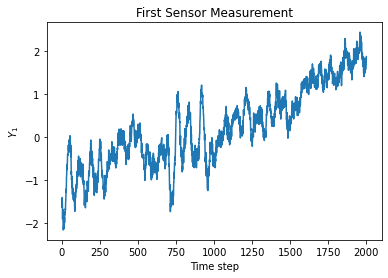

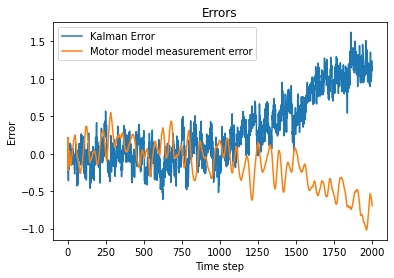

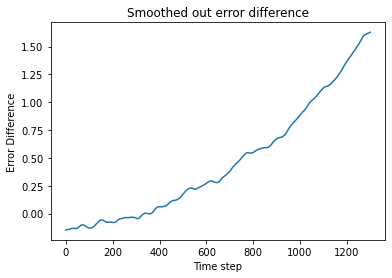

In [88]:
E1s=smoother(E1[300:, 0], 400)    #Smooth the Kalman Error from first sensor
E2s=smoother(E2[300:, 0], 400)    #Smooth the motor model measurement error from first sensor

Ediff=[]

for i in range(0, len(E1s)):
    Ediff.append(E1s[i]-E2s[i])
    
plt.plot(Y1)         #Plot the first Sensor measurements (the one that is simulated for faults)
plt.xlabel("Time step")
plt.ylabel('$Y_1$')
plt.title("First Sensor Measurement")
plt.show()         

plt.plot(E1[:, 0])   #Plot Kalman Error for first sensor
plt.plot(E2[:, 0])   #Plot motor model measurement error from first sensor
plt.xlabel("Time step")
plt.ylabel('Error')
plt.title("Errors")
plt.legend(['Kalman Error', 'Motor model measurement error'])
plt.show()

plt.plot(Ediff)      #Plot smoothed out difference
plt.xlabel("Time step")
plt.ylabel('Error Difference')
plt.title("Smoothed out error difference")
plt.show()

### Real Time Drift detection strategy

If the value of this smoothed difference crosses a threshold value of $0.15$, then keep counting the time instants and adding the 
smoothed difference value until the count becomes larger than certain value 'l'.  Then to an array, append the average value until now of the smoothed error difference and its index. Then if number of elements in this array is greater than 5 then we have detected a drift fault. The following code with comments will explain the idea better

In [89]:
def slopeDetector(Ediff, l):
    
    #Lets see if there is a slope in the smoothed error difference signal
    
    
    #Ediff - > Smoothed error difference signal 
    
    s=0      #sum of error difference
    count=0  #count of values since Error difference crossed a threshold
    Pts=[]   #Array of points
    
    
    for i in range(0, len(Ediff)):
        
        if abs(Ediff[i]-0)<0.15:
            
            #We are okay no threshold breeched
            s=0     #revert the sum back to 0
            count=0 #revert the count back to 0
            
        else:
            
            s+=Ediff[i]   #add to s
            count+=1      #increment count
            
        if count>l:
            #Should the count increase l then
            
            Pts.append([s/count, i])    #To points array s/count i.e. average value since we crossed threshold and index i
            count=0                     #Again make count 0
            s=0                         #Make s 0 again

    #If I have more than 5 points, then I can find the value of drift also using my avg function
    if len(Pts)>=5:
        return avg(Pts)
    
    return 0  #Hmm, everything at least seems okay!


def avg(Pts):
    
    #From the points lets compute the value of drift by looking at the average slope
    
    
    Slopes=[]   #Array to store all possible slopes for averaging
    
    for i in range(0, len(Pts)):
        for j in range(i+1, len(Pts)):
            
            #every possible combination of points
            y=Pts[i][0]-Pts[j][0]  #basically dY
            x=Pts[i][1]-Pts[j][1]  #basically dX
            Slopes.append(y/x)     #Append the slope
            
    return sum(Slopes)/len(Slopes)   #Return the average slope

In [95]:
slopeDetector(Ediff, 40)

0.001771125800784038

The above value is obtained against the simulated value of 0.002. Similar to the function to quantify drift performance this function is built to quantify performance of drift detection

In [41]:
def QuantifyPerformanceDrift(Drift, N=100, smoothtime=100, l=50):
    
    #This function is built to quantify performance of our scheme
    
    #N->Number of simulations
    #Now perform the same above experiment N (default 100) times for a given drift coefficient
    
    Ediff_data=[]   #Store the performance data
    
    for i in range(N):
        
        Y1, Y2, Xplot, E1, E2, X5=DriftPerformance(1000, np.array([Drift,  0]), 2000)  #Do the simulation N times
        
        #Smooth the errors
        E1s=smoother(E1[300:, 0], smoothtime) 
        E2s=smoother(E2[300:, 0], smoothtime)
        Ediff=[]
        for i in range(0, len(E1s)):
            Ediff.append(E1s[i]-E2s[i])
        
        Ediff_data.append(slopeDetector(Ediff, l))
        
    return Ediff_data   #Return the detectors output for each case

The code below was used to generate the data and store the results in a file. It has been commneted out because it takes lot of time to execute. However two data files have been provided

In [ ]:
"""
Ediff_state0=QuantifyPerformance(0)
Ediff_state2=QuantifyPerformance(0.1)
Ediff_state4=QuantifyPerformance(0.2)
Ediff_state6=QuantifyPerformance(0.3)
Ediff_state8=QuantifyPerformance(0.4)
Ediff_state0=QuantifyPerformance(0.5)
Ediff_state2=QuantifyPerformance(0.6)
Ediff_state4=QuantifyPerformance(0.7)
Ediff_state6=QuantifyPerformance(0.8)
Ediff_state8=QuantifyPerformance(0.9)
Ediff_state10=QuantifyPerformance(1)


X0=QuantifyPerformanceDrift(0.000, N=100, smoothtime=100, l=50)
X05=QuantifyPerformanceDrift(0.0005, N=100, smoothtime=100, l=50)
X10=QuantifyPerformanceDrift(0.001, N=100, smoothtime=100, l=50)
X15=QuantifyPerformanceDrift(0.0015, N=100, smoothtime=100, l=50)
X20=QuantifyPerformanceDrift(0.0020, N=100, smoothtime=100, l=50)
X25=QuantifyPerformanceDrift(0.0025, N=100, smoothtime=100, l=50)
X30=QuantifyPerformanceDrift(0.0030, N=100, smoothtime=100, l=50)
X40=QuantifyPerformanceDrift(0.0035, N=100, smoothtime=100, l=50)
X45=QuantifyPerformanceDrift(0.0040, N=100, smoothtime=100, l=50)
X50=QuantifyPerformanceDrift(0.0045, N=100, smoothtime=100, l=50)

file=open('OffsetData.txt', 'w')

file.write('Offset 0'+'\n'+'\n')
for i in Ediff_state0:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Offset 0.1'+'\n'+'\n')
for i in Ediff_state1:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Offset 0.2'+'\n'+'\n')
for i in Ediff_state2:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Offset 0.3'+'\n'+'\n')
for i in Ediff_state3:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Offset 0.4'+'\n'+'\n')
for i in Ediff_state4:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Offset 0.5'+'\n'+'\n')
for i in Ediff_state5:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Offset 0.6'+'\n'+'\n')
for i in Ediff_state6:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Offset 0.7'+'\n'+'\n')
for i in Ediff_state7:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Offset 0.8'+'\n'+'\n')
for i in Ediff_state8:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Offset 0.9'+'\n'+'\n')
for i in Ediff_state9:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Offset 1.0'+'\n'+'\n')
for i in Ediff_state10:
    file.write(str(i)+'\n')
file.write('\n')

file=open('Drift_Data.txt', 'w')

file.write('Drift 0'+'\n'+'\n')
for i in X0:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Drift 0.0005'+'\n'+'\n')
for i in X05:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Drift 0.001'+'\n'+'\n')
for i in X10:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Drift 0.0015'+'\n'+'\n')
for i in X15:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Drift 0.002'+'\n'+'\n')
for i in X20:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Drift 0.0025'+'\n'+'\n')
for i in X25:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Drift 0.0030'+'\n'+'\n')
for i in X30:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Drift 0.0035'+'\n'+'\n')
for i in X40:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Drift 0.0040'+'\n'+'\n')
for i in X45:
    file.write(str(i)+'\n')
file.write('\n')
file.write('Drift 0.0045'+'\n'+'\n')
for i in X50:
    file.write(str(i)+'\n')
file.write('\n')

"""

The data is plotted in the PDF report